In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from functions import colorize, generate_reference, generate_complex_pattern

# I. Generate syntetic data

## I.1. Generate complex pattern, reference

Text(0.5, 1.0, 'Reference (phase slope)')

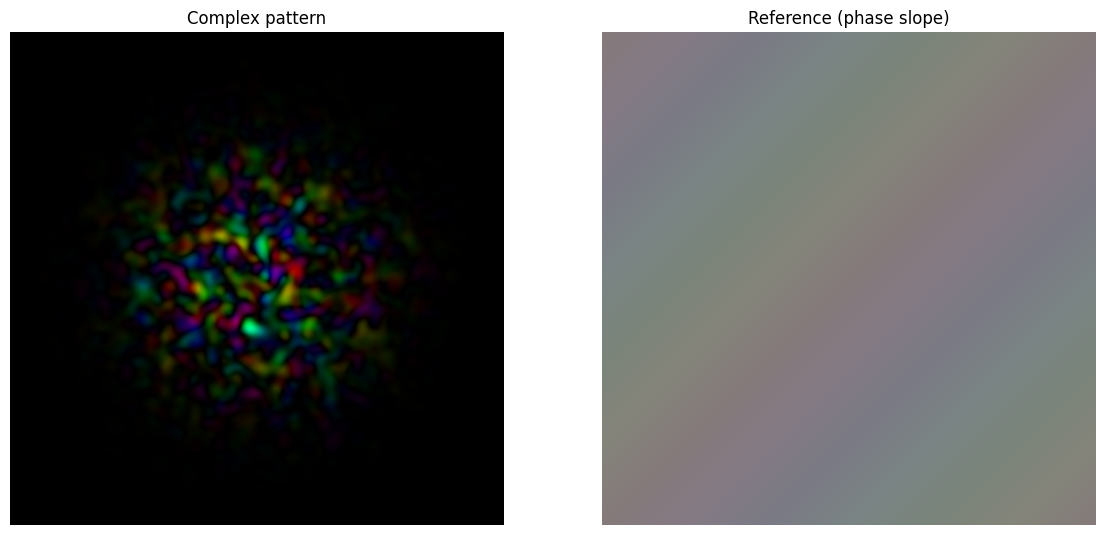

In [41]:
N = 2000
# sigma of the pixel size (relative to the full window size)
sigma = 1e-2
# sigma of the envelope (relative to the full window size)
sigma_env = 0.33
# angle of the reference phase slope
angle = np.pi/4
# spatial frequency of the reference phase slope
fx, fy = 0.2,0.2


complex_pattern, X, Y = generate_complex_pattern(N, sigma, sigma_env)
reference = generate_reference(X, Y, fx, fy)


plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow(colorize(complex_pattern))
plt.axis('off')
plt.title('Complex pattern')
plt.subplot(122)
plt.imshow(colorize(reference))
plt.axis('off')
plt.title('Reference (phase slope)')


## I.2. Compute interferogram

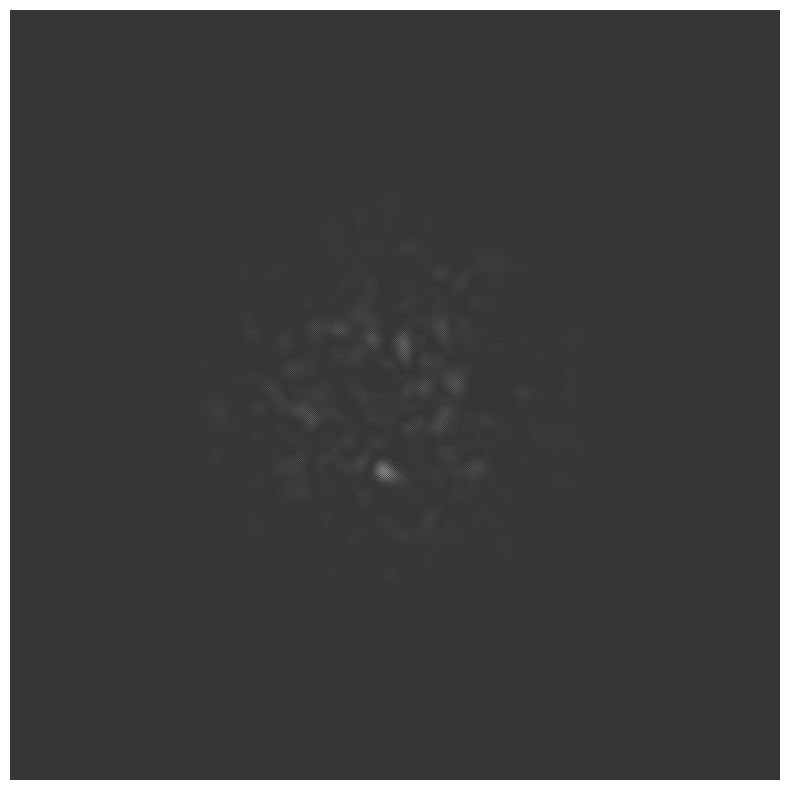

In [ ]:
off_axis_intensity = np.abs(reference+complex_pattern)**2

plt.figure(figsize=(10, 10))
plt.imshow(np.abs(off_axis_intensity), cmap='gray')
plt.axis('off')

# II. Off-axis with ZoomFFT

## II.1. ZoomFFT

In [43]:
from zoomfft2 import ZoomFFT2D

## II.2. Compute Fourier transform

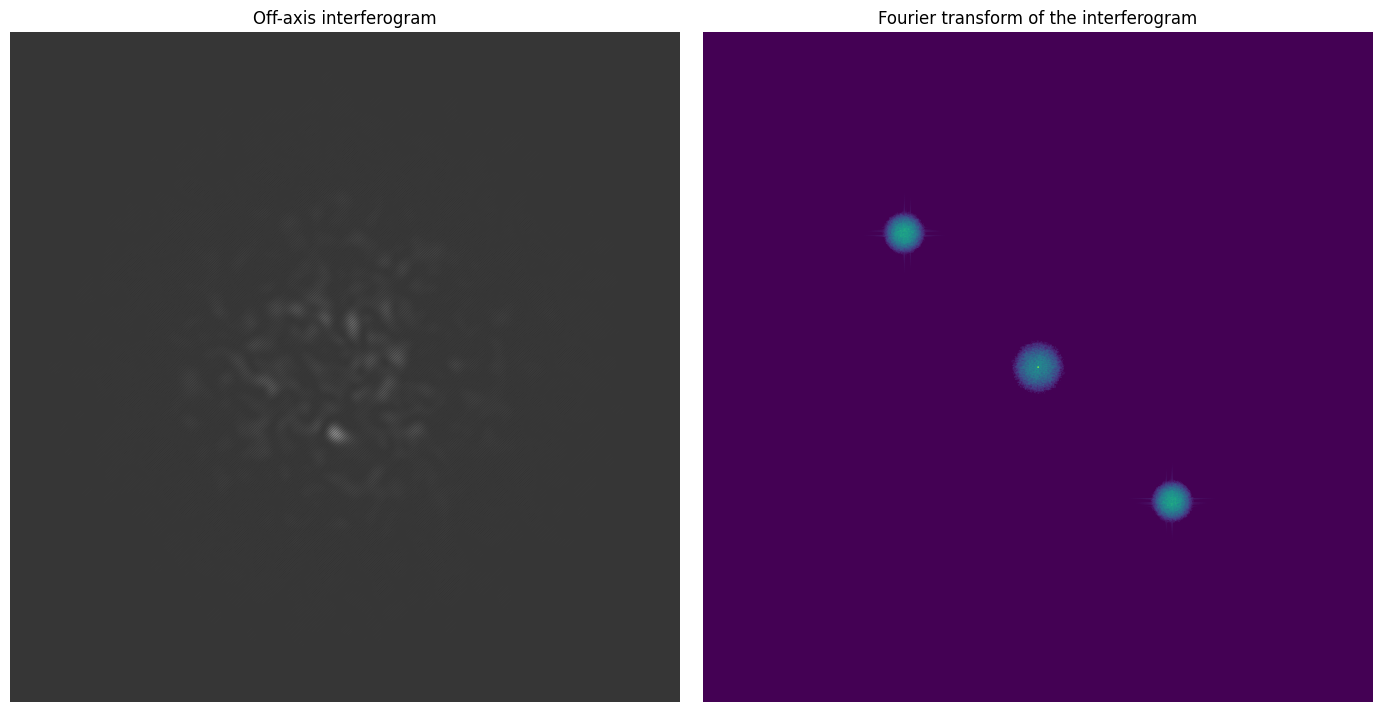

In [60]:
from matplotlib.colors import LogNorm

# Create the ZoomFFT object for the full FFT (slow!)
ft = ZoomFFT2D(off_axis_intensity.shape, off_axis_intensity.shape, 0., 1.)

# compute FFT of the interferogram
ft_img = ft(off_axis_intensity)

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow(off_axis_intensity, cmap = 'gray')
plt.axis('off')
plt.title('Off-axis interferogram')
plt.subplot(122)
plt.imshow(np.abs(ft_img)/np.max(np.abs(ft_img)),  norm=LogNorm(vmin=1e-6, vmax=1))
plt.axis('off')
plt.title('Fourier transform of the interferogram')
plt.tight_layout()
plt.show()

## II.3 Select the desired frequency window

Text(0.5, 1.0, 'Frequency window')

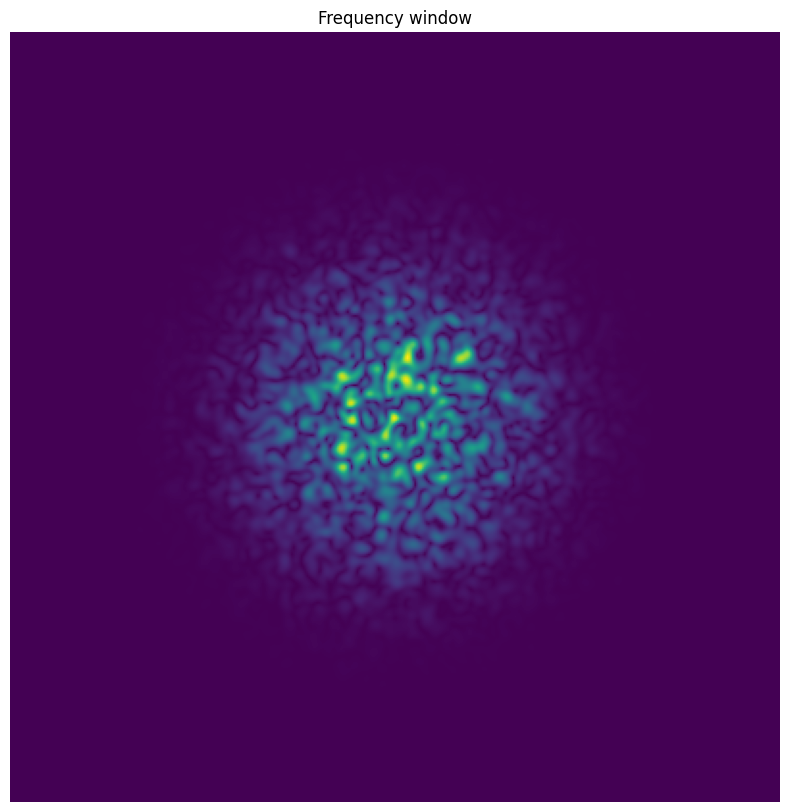

In [ ]:
f_range = 0.075
ft_res = 400
window_resolution = (ft_res, ft_res)


## Note that we take the minus sign to select the -1 order
## The +1 order contains the conjugate of the signal
f_center = (-fx, -fy)

ft_small = ZoomFFT2D(
    off_axis_intensity.shape, 
    window_resolution,
    f_center = f_center,
    f_range = f_range,
    )

ft_small_img = ft_small(off_axis_intensity)


plt.figure(figsize=(10, 10))
plt.imshow(np.abs(ft_small_img)/np.max(np.abs(ft_small_img)))
plt.axis('off')
plt.title('Frequency window selected by the mask')


## II.4. Inverse FT

In [46]:
# to recover the original pattern size, we need to set the f_range 
# in agreement with original size and the resolution of the zoomFFT window
if_range = N/ft_res*f_range


ift = ZoomFFT2D(
    ft_small_img.shape,
    off_axis_intensity.shape,
    f_center = 0.,
    f_range = if_range, 
    direction='backward'
    )
recovered_complex_pattern = ift(ft_small_img)

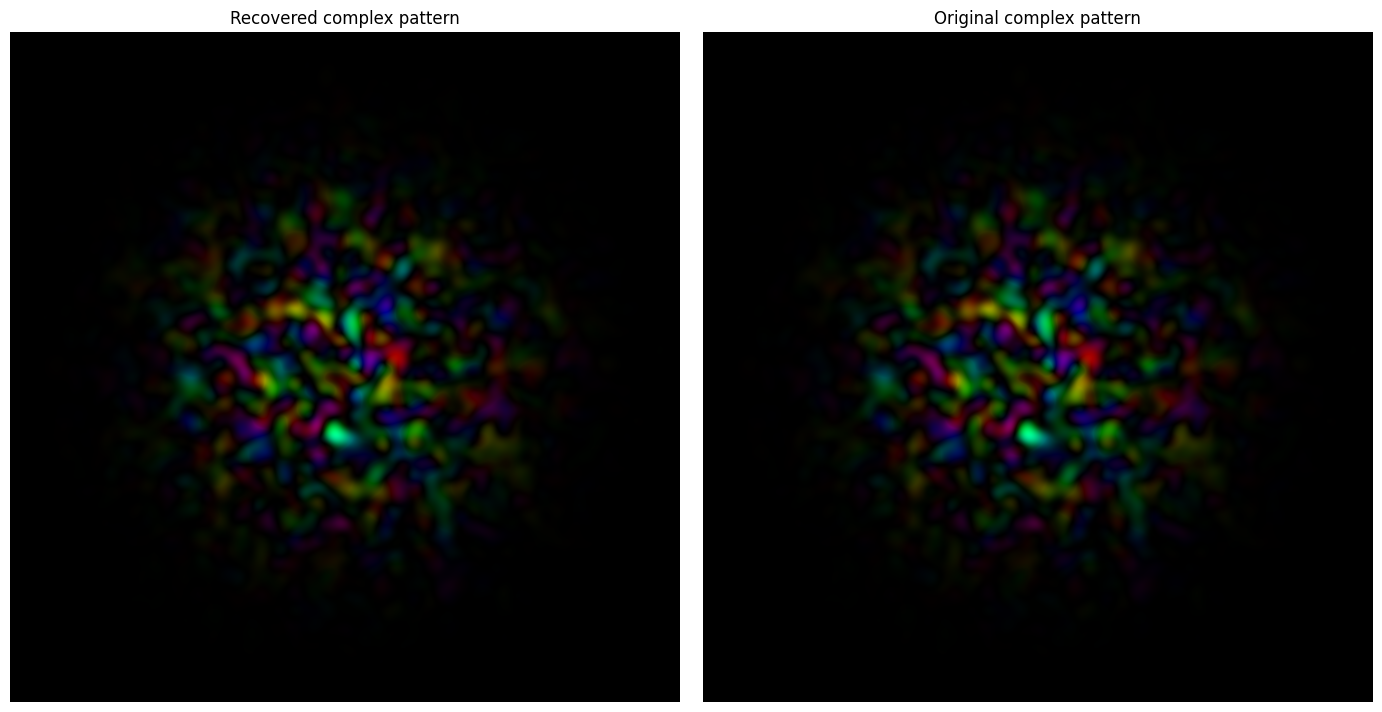

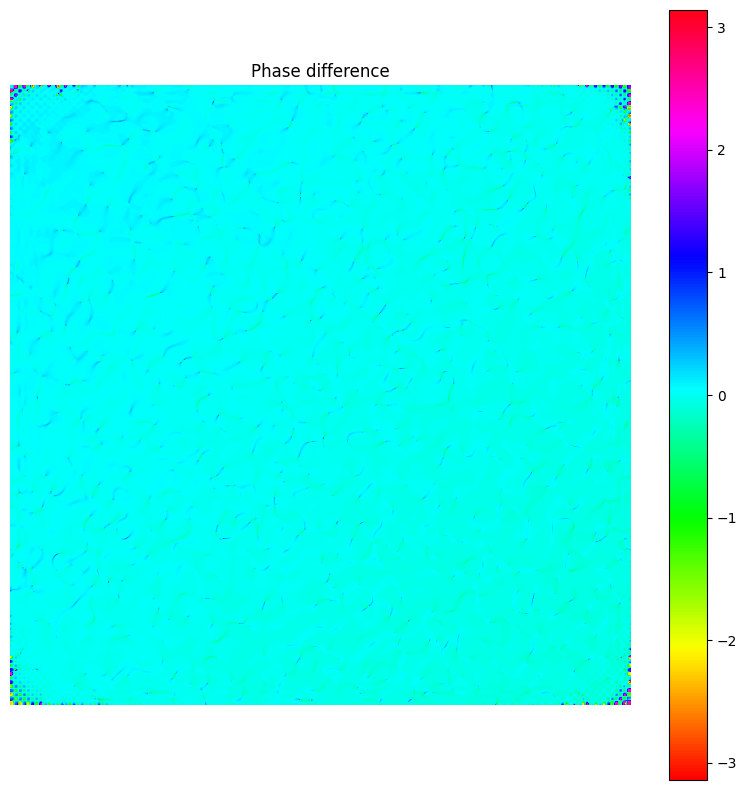

In [61]:
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow(colorize(recovered_complex_pattern))
plt.axis('off')
plt.title('Recovered complex pattern')
plt.subplot(122)
plt.imshow(colorize(complex_pattern))
plt.axis('off')
plt.title('Original complex pattern')
plt.tight_layout()

plt.figure(figsize=(10, 10))
plt.imshow(np.angle(recovered_complex_pattern/complex_pattern), cmap='hsv')
plt.axis('off')
plt.title('Phase difference')
plt.colorbar()


## III. Off-axis with `np.fft` 

Note that to compare the two approaches on the same ground, we compute the fft over a number of frequencies (`fft_size`) 
so that the window of selected frequencies matches the size of the one using ZoomFFT, i.e. `window_resolution`.


Fraction of spatial frequencies selected by the mask=0.005625703190923462


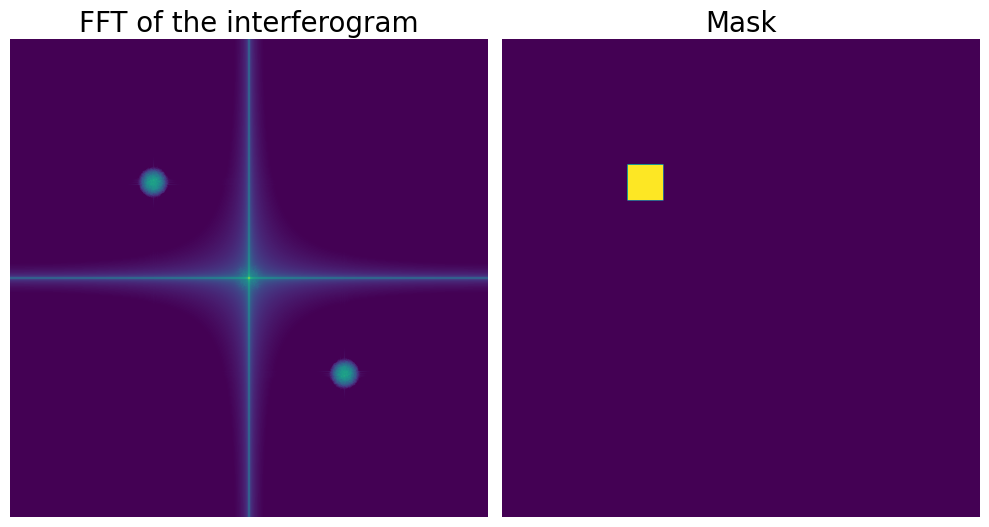

In [ ]:
fft_size = [int(ft_res/f_range)]*2

# Compute the FFT of the interferogram
Fh = np.fft.fftshift(np.fft.fft2(off_axis_intensity, fft_size).astype(complex))
fft_freq = np.fft.fftshift(np.fft.fftfreq(fft_size[0]))

# Compute the mask
mask_FT_x = (fft_freq > f_center[0]-f_range/2) * (fft_freq < f_center[0]+f_range/2)
mask_FT_y = (fft_freq > f_center[1]-f_range/2) * (fft_freq < f_center[1]+f_range/2)
# outer product
mask_FT = np.outer(mask_FT_x, mask_FT_y)

plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(np.abs(Fh)/np.max(np.abs(Fh)), norm=LogNorm(vmin=1e-6, vmax=1))
plt.axis('off')
plt.title('FFT of the interferogram', fontsize=20)
plt.subplot(122)
plt.imshow(mask_FT)
plt.axis('off')
plt.title('Mask', fontsize=20)
plt.tight_layout()
plt.savefig('mask.png', dpi=150)

print(f"Fraction of spatial frequencies selected by the mask={np.sum(mask_FT)/np.prod(mask_FT.shape)}")


## V. Speed tests

### V.1. Define functions for both approaches

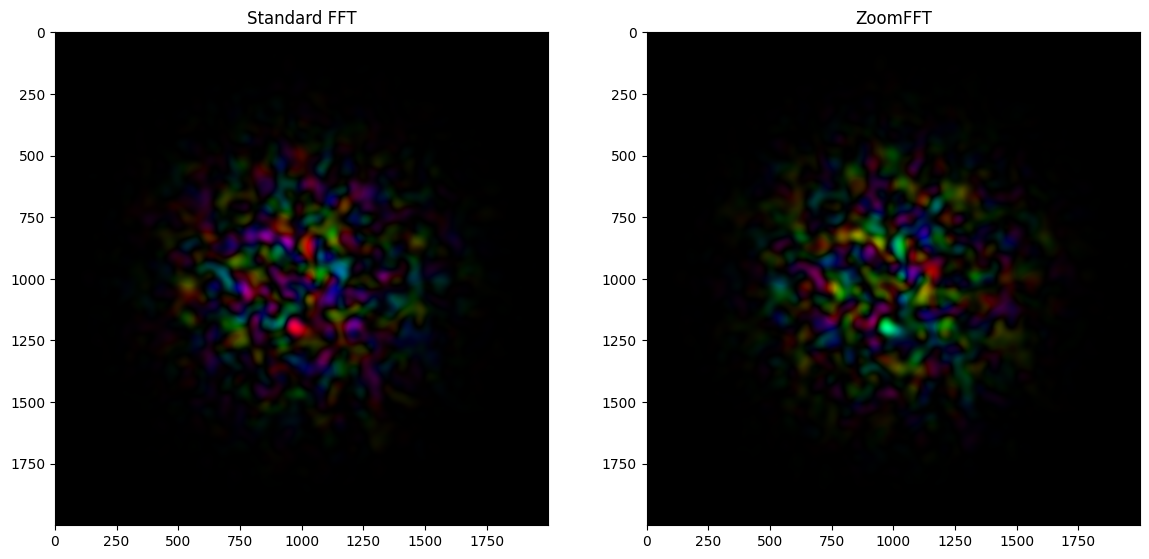

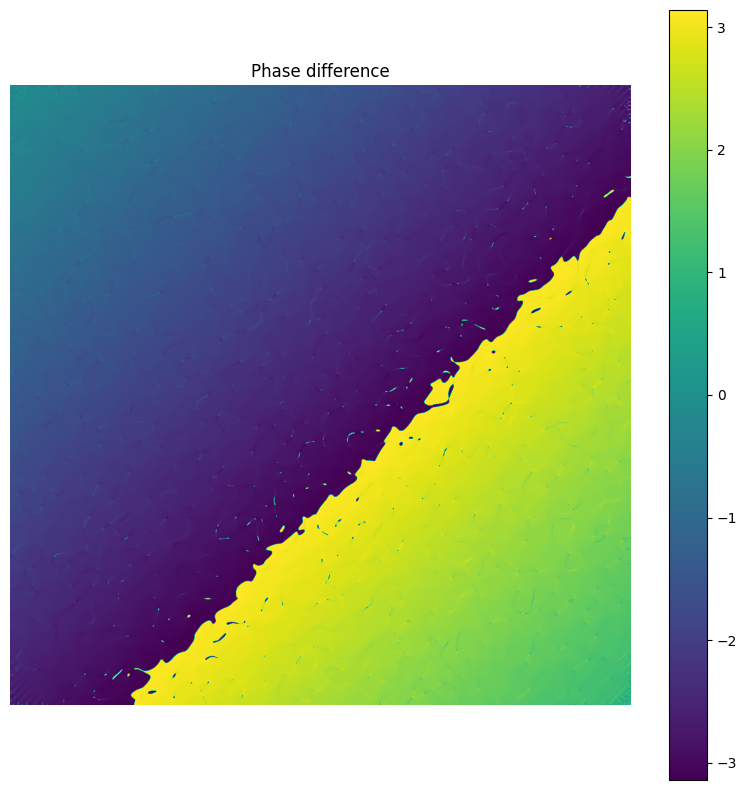

In [ ]:
def do_offaxis_FFT(A, mask, f_center):
    Fh = np.fft.fftshift(np.fft.fft2(A, s = fft_size).astype(complex))
    ## Apply mask
    Fh_masked = Fh*mask
    offset = [-int(f*n) for f,n in zip(f_center,fft_size)]
    ## Recenter the FFT 
    Fh_recentered = np.roll(Fh_masked, offset[0], axis=0)
    Fh_recentered = np.roll(Fh_recentered, offset[1], axis=1)  
    ## Inverse FFT
    fft_recovered = np.fft.ifft2(np.fft.ifftshift(Fh_recentered))
    return fft_recovered[:A.shape[0], :A.shape[1]]


def do_offaxis_FFT_zoom(A):
    ft_small_img = ft_small(A)
    recovered_complex_pattern = ift(ft_small_img)
    return recovered_complex_pattern


fft_recovered_FFT = do_offaxis_FFT(off_axis_intensity, mask_FT, f_center)
fft_recovered_FFT_zoom = do_offaxis_FFT_zoom(off_axis_intensity)


### V.2. Compare results

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow(colorize(fft_recovered_FFT))
# plt.colorbar()
# plt.axis('off')
plt.title('Standard FFT')
plt.subplot(122)
plt.imshow(colorize(fft_recovered_FFT_zoom))
# plt.axis('off')
plt.title('ZoomFFT')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(np.angle(fft_recovered_FFT/fft_recovered_FFT_zoom))
plt.axis('off')
plt.title('Phase difference')
plt.colorbar()

### V.3. Measure average computation time

In [50]:
%%timeit 

fft_recovered_FFT = do_offaxis_FFT(off_axis_intensity, mask_FT, f_center)


3.77 s ± 81.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit #-n 10 -r 10
fft_recovered_FFT_zoom = do_offaxis_FFT_zoom(off_axis_intensity)

322 ms ± 7.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
